# 03：ミニバッチを用いたMLPの学習


---
## 目的
多層パーセプトロン（Multi Layer Perceptron; MLP）を用いて，乳癌データの2クラス分類を行う．
ミニバッチ学習について理解する．


## モジュールのインポート
プログラムの実行に必要なモジュールをインポートします．

In [14]:
import numpy as np
import matplotlib.pyplot as plt

## データセットの読み込み
実験に使用するデータセットを読み込みます．

今回は**Breast Cancer Wisconsin Dataset**を用いて2クラス分類を行います．
breast cancer datasetは乳癌のデータセットであり，クラス数は悪性腫瘍 (malignant)と良性腫瘍 (benign) の2クラス，データ数は569（悪性腫瘍 (malignant): 220, 良性腫瘍 (benign): 357）のデータセットです．
各データは細胞核の半径や面積，テクスチャ情報を表現した30次元のベクトルデータです．

[Breast Cancer Wisconsin (Diagnostic) Data Set](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic))

はじめに，`wget`コマンドを使用して，データセットのファイルをダウンロードします．

次に，データと正解ラベルが含まれている`breast_cancer.csv`を読み込みます．
読み込んだデータのうち，最初の30列に各データを表現した30次元のベクトルデータが格納されており，最後の1列に正解ラベル`(0, 1)`が格納されています．これらをそれぞれ，`x`と`y`に分割して格納します．

In [15]:
# データセットのダウンロード
!wget -q http://www.mprg.cs.chubu.ac.jp/~hirakawa/share/tutorial_data/breast_cancer.csv -O breast_cancer.csv

# データセットの読み込み
breast_cancer_data = np.loadtxt("breast_cancer.csv", dtype=np.float32, delimiter=",")
x = breast_cancer_data[:, :-1]
y = breast_cancer_data[:, -1].astype(np.int32)

print(x.shape, x.dtype)
print(y.shape, y.dtype)

(569, 30) float32
(569,) int32


## データの分割と正規化
上記で読み込んだデータを学習用データとテストデータに分割し，正規化を行います．

データの分割では，`test_sample_ratio`で，テストに用いるサンプルの割合を指定します．
その後，データの総数から，学習とテストにするデータの数を算出し，ランダムにサンプルを振り分けます．
このとき，`np.random.seed`はデータをランダムに分割する際のseedです．
seedを変更，または指定しないことで，無作為にデータを分割することが可能です．

次に正規化を行います．
データ$x$の最小値を$x_{min}$，最大値を$x_{max}$としたとき，次の式で正規化を行います．
$$x_{norm} = \frac{x - x_{min}}{x_{max} - x_{min}}$$

`np.min`と`np.max`で学習データの最大，最小値を取得し，上記の式に従い0~1の範囲に値を正規化します．

In [16]:
# データの分割
test_sample_ratio = 0.2  # テストデータの割合を指定
num_data = x.shape[0]    # データの総数
num_test = int(num_data * test_sample_ratio)
num_train = num_data - num_test

np.random.seed(seed=0)
random_index = np.random.permutation(num_data)
x_train = x[random_index[0:num_train]]
y_train = y[random_index[0:num_train]]
x_test = x[random_index[num_train:]]
y_test = y[random_index[num_train:]]

# データの正規化
x_min = np.min(x_train, axis=0)
x_max = np.max(x_train, axis=0)

x_train = (x_train[:, ] - x_min) / (x_max - x_min)
x_test = (x_test[:, ] - x_min) / (x_max - x_min)

## ミニバッチ学習を考慮したネットワークモデルの定義
次に，ニューラルネットワーク（多層パーセプトロン）を定義します．

---
### ミニバッチ学習
前回の演習プログラムでは，1サンプルごとに学習するオンライン学習とデータセットのサンプル全てを一度に使用して学習するバッチ学習を行いました．

それに対して，**ミニバッチ学習**は，事前に決定した数のサンプルを一度に使用してネットワークのパラメータ更新を行う学習方法です．
例えば，ミニバッチサイズ（バッチサイズ）を10とした場合，データセットの中からランダムに10サンプルを選択し，それらのサンプルから得られる勾配情報を元にパラメータ更新を行います．

---

まずはじめに，ネットワークの定義に必要な関数を定義します．

In [17]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_grad(x):
    return (1.0 - sigmoid(x)) * sigmoid(x)

上で定義した関数を用いてミニバッチ学習に対応するネットワークモデルを作成します．
ここでは，入力層，中間層，出力層から構成される多層パーセプトロンを定義します．

入力層と中間層のユニット数は引数として与え，それぞれ`input_size`，`hidden_size`とします．
出力層サイズについては，今回は2クラス分類問題を扱うため，`0~1`でどちらのクラスに属するかを表現するように，ユニット数は1に固定します．
そして，`__init__`関数を用いて，ネットワークのパラメータを初期化します．
`w1`および`w2`は各層の重みで，`b1`および`b2`はバイアスを表しています．
重みは`randn`関数で，標準正規分布に従った乱数で生成した値を保有する配列を生成します．
バイアスは`zeros`関数を用いて，要素が全て0の配列を生成します．

そして，`forward`関数で，データを入力して結果を出力するための演算を定義します．
ここでの演算は前回の演習プログラムと同様の処理を行います．

次に，`backward`関数ではパラメータの更新量を計算します．
まず，ネットワークの出力結果と教師ラベルから，誤差`dy`を算出します．
その後，連鎖律に基づいて，出力層から順番に勾配を計算していきます．
このとき，パラメータの更新量を`self.grads`へ保存しておきます．
この時，ミニバッチ内の複数のサンプルの情報から勾配を決定するために，
全結合層では`np.dot(self.h2.T, d_h3)`のように，行列を転置させて演算を行なっていることに注意していください．
また，バイアスについては，各サンプルから得られた情報を`np.sum()`によって和を取っています．

最後に`update_parameters`関数で，更新量をもとにパラメータの更新を行います．

In [18]:
class MLPBernoulli:
    
    def __init__(self, input_size, hidden_size, w_std=0.01):
        self.w1 = w_std * np.random.randn(input_size, hidden_size)
        self.b1 = np.zeros(hidden_size)
        self.w2 = w_std * np.random.randn(hidden_size, 1)
        self.b2 = np.zeros(1)        
        self.grads = {}

    def forward(self, x):
        self.h1 = np.dot(x, self.w1) + self.b1
        self.h2 = sigmoid(self.h1)
        self.h3 = np.dot(self.h2, self.w2) + self.b2
        self.y = sigmoid(self.h3)
        return self.y

    def backward(self, x, t): 
        self.grads = {}

        dy = (t - self.y)
        d_h3 = sigmoid_grad(self.h3) * dy
        self.grads['w2'] = np.dot(self.h2.T, d_h3)
        self.grads['b2'] = np.sum(d_h3, axis=0)

        d_h2 = np.dot(d_h3, self.w2.T)
        d_h1 = sigmoid_grad(self.h1) * d_h2
        self.grads['w1'] = np.dot(x.T, d_h1)
        self.grads['b1'] = np.sum(d_h1, axis=0)

    def update_parameters(self, lr=0.1):
        self.w1 += lr * self.grads['w1']
        self.b1 += lr * self.grads['b1']
        self.w2 += lr * self.grads['w2']
        self.b2 += lr * self.grads['b2']

## ネットワークの作成と学習の準備
上のプログラムで定義したネットワークを作成します．


まず，中間層と出力層のユニット数を定義します．
ここでは，入力層のユニット数`input_size`を学習データの次元，中間層のユニット数`hidden_size`を128とします．

各層のユニット数を`MLPBernoulli`クラスの引数として与え，ネットワークを作成します．

### ミニバッチ学習で扱うデータ（配列）の形式
作成したネットワークへの入力と出力，教師ラベルのデータ配列のサイズ・形を確認します．
ここでは，上で用意したデータセット（`x_train`, `y_train`）のうち，先頭の10サンプルを`input`, `label`として保存します．
その後，`input`データを`model.forward()`関数に入力し，分類結果を`y`として受け取ります．

**※ ネットワークの学習はまだ行われていないため，分類結果は正しいものとは限らないことに注意してください．**

ここで，入力，出力，教師ラベルの配列サイズを確認します．
入力データは，`(10, 30)`となっており，1次元目がミニバッチサイズに対応しており，2次元目が各サンプルの特徴次元数となっています．
また，出力データのサイズは`(10, 1)`となっており，入力と同様に1次元目がミニバッチサイズ，2次元目は各サンプルの出力次元数となっています．このネットワークでは分類結果を0~1のスコアで出力するため，次元数は1となっています．
また，`y_train`から取り出した教師ラベルのサイズは`(10,)`となっており，1次元の配列（ベクトル）となっています．
学習時の誤差計算に使用するためには，出力データと配列の形を合わせる必要があります．そのために，`reshape()`という関数を適用し，配列の形状を変更することで，対応します．
`reshape(-1, 1)`では，2次元の配列に変更しており，2次元目のサイズを1，1次元目のサイズを-1とすることで任意のサイズに変更します．


In [19]:
input_size = x.shape[1]
hidden_size = 64
model = MLPBernoulli(input_size=input_size, hidden_size=hidden_size)

# 確認用データの準備
input = x_train[0:10]
print("input data shape:", input.shape)

y = model.forward(input)
print("output data shape:", y.shape)

label = y_train[0:10]
print("label data shape:", label.shape)
print("label data shape (reshaped):", label.reshape(-1, 1).shape)

input data shape: (10, 30)
output data shape: (10, 1)
label data shape: (10,)
label data shape (reshaped): (10, 1)


## 学習
読み込んだbreast cancerデータセットと作成したネットワークを用いて，学習を行います．

1回の誤差を算出するデータ数（ミニバッチサイズ）を10，学習エポック数を100とします．

学習データは毎回ランダムに決定するため，numpyの`permutation`という関数を利用します．
各更新において，学習用データと教師データをそれぞれ`x_batch`と`y_batch`とします．
学習モデルに`x_batch`を与えて，各クラスに対する分類スコア`y_pred`を求めます．
取得した`y_pred`は，学習の推移を確認するために，精度および誤差の算出に使用され，値を保存します．
そして，誤差を`backward`関数で逆伝播します．この時，教師ラベル`y_batch`の配列サイズを`reshape()`を用いて，`y_pred`と同じ配列サイズに変更して入力します．
そして，`update_parameters`でネットワークの更新を行います．

In [20]:
# 学習途中の精度を確認するための関数
def binary_classification_accuracy(pred, true):
    pred = pred.flatten()
    clf_res = np.zeros(pred.shape, dtype=np.int32)
    clf_res[pred > 0.5] = 1
    return np.sum(clf_res == true).astype(np.float32)

num_train_data = x_train.shape[0]
num_test_data = x_test.shape[0]
epoch_num = 100
batch_size= 10
learning_rate = 0.01

epoch_list = []
itr_list = []
itr_loss_list = []
train_loss_list = []
train_accuracy_list = []
test_accuracy_list = []

iteration = 0
for epoch in range(1, epoch_num + 1):
    sum_accuracy = 0.0
    sum_loss = 0.0

    perm = np.random.permutation(num_train_data)
    for i in range(0, num_train_data, batch_size):
        x_batch = x_train[perm[i:i+batch_size]]
        y_batch = y_train[perm[i:i+batch_size]]
        
        y_pred = model.forward(x_batch)

        sum_accuracy += binary_classification_accuracy(y_pred, y_batch)
        sum_loss += np.sum(np.power(y_pred - y_batch.reshape(-1, 1), 2))
        itr_loss_list.append(np.sum(np.power(y_pred - y_batch.reshape(-1, 1), 2)))
        itr_list.append(iteration)
        
        model.backward(x_batch, y_batch.reshape(-1, 1))
        model.update_parameters(lr=learning_rate)

        iteration += 1

    if epoch % 10 == 0:       
        print("epoch: {} (iteration: {}), mean loss: {}, mean accuracy: {}".format(epoch, iteration,
                                                                   sum_loss / num_train_data,
                                                                   sum_accuracy / num_train_data))

    test_correct_count = 0
    for i in range(num_test_data):
        input = x_test[i]
        label = y_test[i]
        y = model.forward(input)
        
        if y[0] > 0.5:
            pred = 1
        else:
            pred = 0
        if pred == label:
            test_correct_count += 1

    # 学習途中のlossと精度の保存
    epoch_list.append(epoch)
    train_loss_list.append(sum_loss / num_train_data)
    train_accuracy_list.append(sum_accuracy / num_train_data)
    test_accuracy_list.append(test_correct_count / num_test_data)

epoch: 10 (iteration: 460), mean loss: 0.23517209040821774, mean accuracy: 0.6293859649122807
epoch: 20 (iteration: 920), mean loss: 0.2322968838100845, mean accuracy: 0.6293859649122807
epoch: 30 (iteration: 1380), mean loss: 0.2314196698179949, mean accuracy: 0.6293859649122807
epoch: 40 (iteration: 1840), mean loss: 0.22416693972119398, mean accuracy: 0.6293859649122807
epoch: 50 (iteration: 2300), mean loss: 0.20483201565280718, mean accuracy: 0.6381578947368421
epoch: 60 (iteration: 2760), mean loss: 0.16452778469758852, mean accuracy: 0.8026315789473685
epoch: 70 (iteration: 3220), mean loss: 0.12172442100205123, mean accuracy: 0.8969298245614035
epoch: 80 (iteration: 3680), mean loss: 0.09411928911182774, mean accuracy: 0.9385964912280702
epoch: 90 (iteration: 4140), mean loss: 0.07726060252674442, mean accuracy: 0.9385964912280702
epoch: 100 (iteration: 4600), mean loss: 0.0676865452754747, mean accuracy: 0.9385964912280702


## テスト
学習したネットワークを用いて，テストデータに対する認識率の確認を行います．

In [21]:
count = 0
num_test_data = x_test.shape[0]

for i in range(num_test_data):
    x = np.array([x_test[i]], dtype=np.float32)
    t = y_test[i]
    y = model.forward(x)
    
    if y[0, 0] > 0.5:
        pred = 1
    else:
        pred = 0
    
    if pred == t:
        count += 1

print("test accuracy: {}".format(count / num_test_data))

test accuracy: 0.9823008849557522


## 学習推移のグラフ化

上の学習プログラムで保存しておいた誤差および精度のデータをグラフ化します．


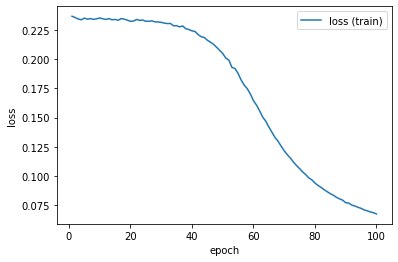

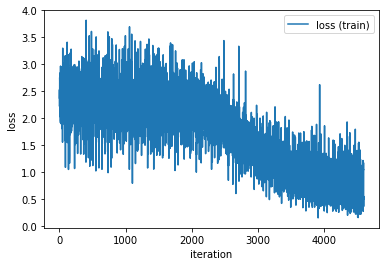

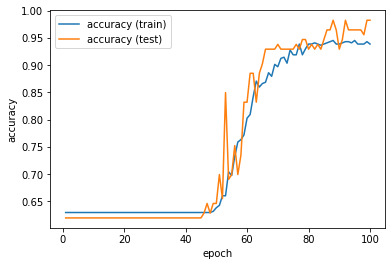

In [22]:
plt.figure()
plt.plot(epoch_list, train_loss_list, label='loss (train)')
plt.xlabel("epoch")     # x軸ラベル
plt.ylabel("loss")      # y軸ラベル
plt.legend()            # 凡例
plt.show()

plt.figure()
plt.plot(itr_list, itr_loss_list, label='loss (train)')
plt.xlabel("iteration")     # x軸ラベル
plt.ylabel("loss")      # y軸ラベル
plt.legend()            # 凡例
plt.show()

plt.figure()
plt.plot(epoch_list, train_accuracy_list, label='accuracy (train)')
plt.plot(epoch_list, test_accuracy_list, label='accuracy (test)')
plt.xlabel("epoch")     # x軸ラベル
plt.ylabel("accuracy")  # y軸ラベル
plt.legend()            # 凡例
plt.show()

## 課題
1. ミニバッチのサイズを大きく変更し学習の推移を確認しよう．ミニバッチのサイズを変えた際のイタレーションとエポックの関係を理解しよう
2. 02の結果を合わせて，オンライン学習，ミニバッチ学習，バッチ学習を比較し，それぞれの特性をまとめよう